In [1]:
import numpy as np 
import pandas as pd

In [3]:
wholesale = pd.read_csv('wholesale.csv')
print(wholesale.head(5))

   Channel  Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0        2       3  12669  9656     7561     214              2674        1338
1        2       3   7057  9810     9568    1762              3293        1776
2        2       3   6353  8808     7684    2405              3516        7844
3        1       3  13265  1196     4221    6404               507        1788
4        2       3  22615  5410     7198    3915              1777        5185


In [4]:
# Drop columns Chennel and Region
wholesale = wholesale.drop(columns=['Channel', 'Region'])

In [5]:
# Explore variables
print(wholesale.describe())

               Fresh          Milk       Grocery        Frozen  \
count     440.000000    440.000000    440.000000    440.000000   
mean    12000.297727   5796.265909   7951.277273   3071.931818   
std     12647.328865   7380.377175   9503.162829   4854.673333   
min         3.000000     55.000000      3.000000     25.000000   
25%      3127.750000   1533.000000   2153.000000    742.250000   
50%      8504.000000   3627.000000   4755.500000   1526.000000   
75%     16933.750000   7190.250000  10655.750000   3554.250000   
max    112151.000000  73498.000000  92780.000000  60869.000000   

       Detergents_Paper    Delicassen  
count        440.000000    440.000000  
mean        2881.493182   1524.870455  
std         4767.854448   2820.105937  
min            3.000000      3.000000  
25%          256.750000    408.250000  
50%          816.500000    965.500000  
75%         3922.000000   1820.250000  
max        40827.000000  47943.000000  


In [7]:
# Get the statistics
averages = wholesale.mean()
st_dev = wholesale.std()
x_names = wholesale.columns
x_ix = np.arange(wholesale.shape[1])

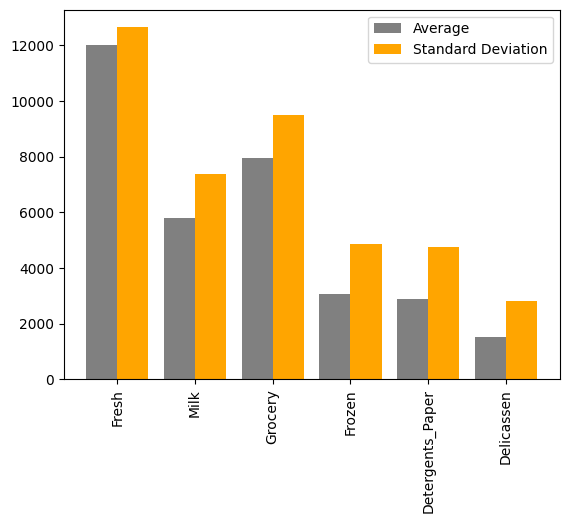

In [9]:
# Plot the data
import matplotlib.pyplot as plt
plt.bar(x_ix - 0.2, averages, width=0.4, label='Average', color='grey')
plt.bar(x_ix + 0.2, st_dev, width=0.4, label='Standard Deviation', color='orange')
plt.xticks(x_ix, x_names, rotation=90)
plt.legend()
plt.show()

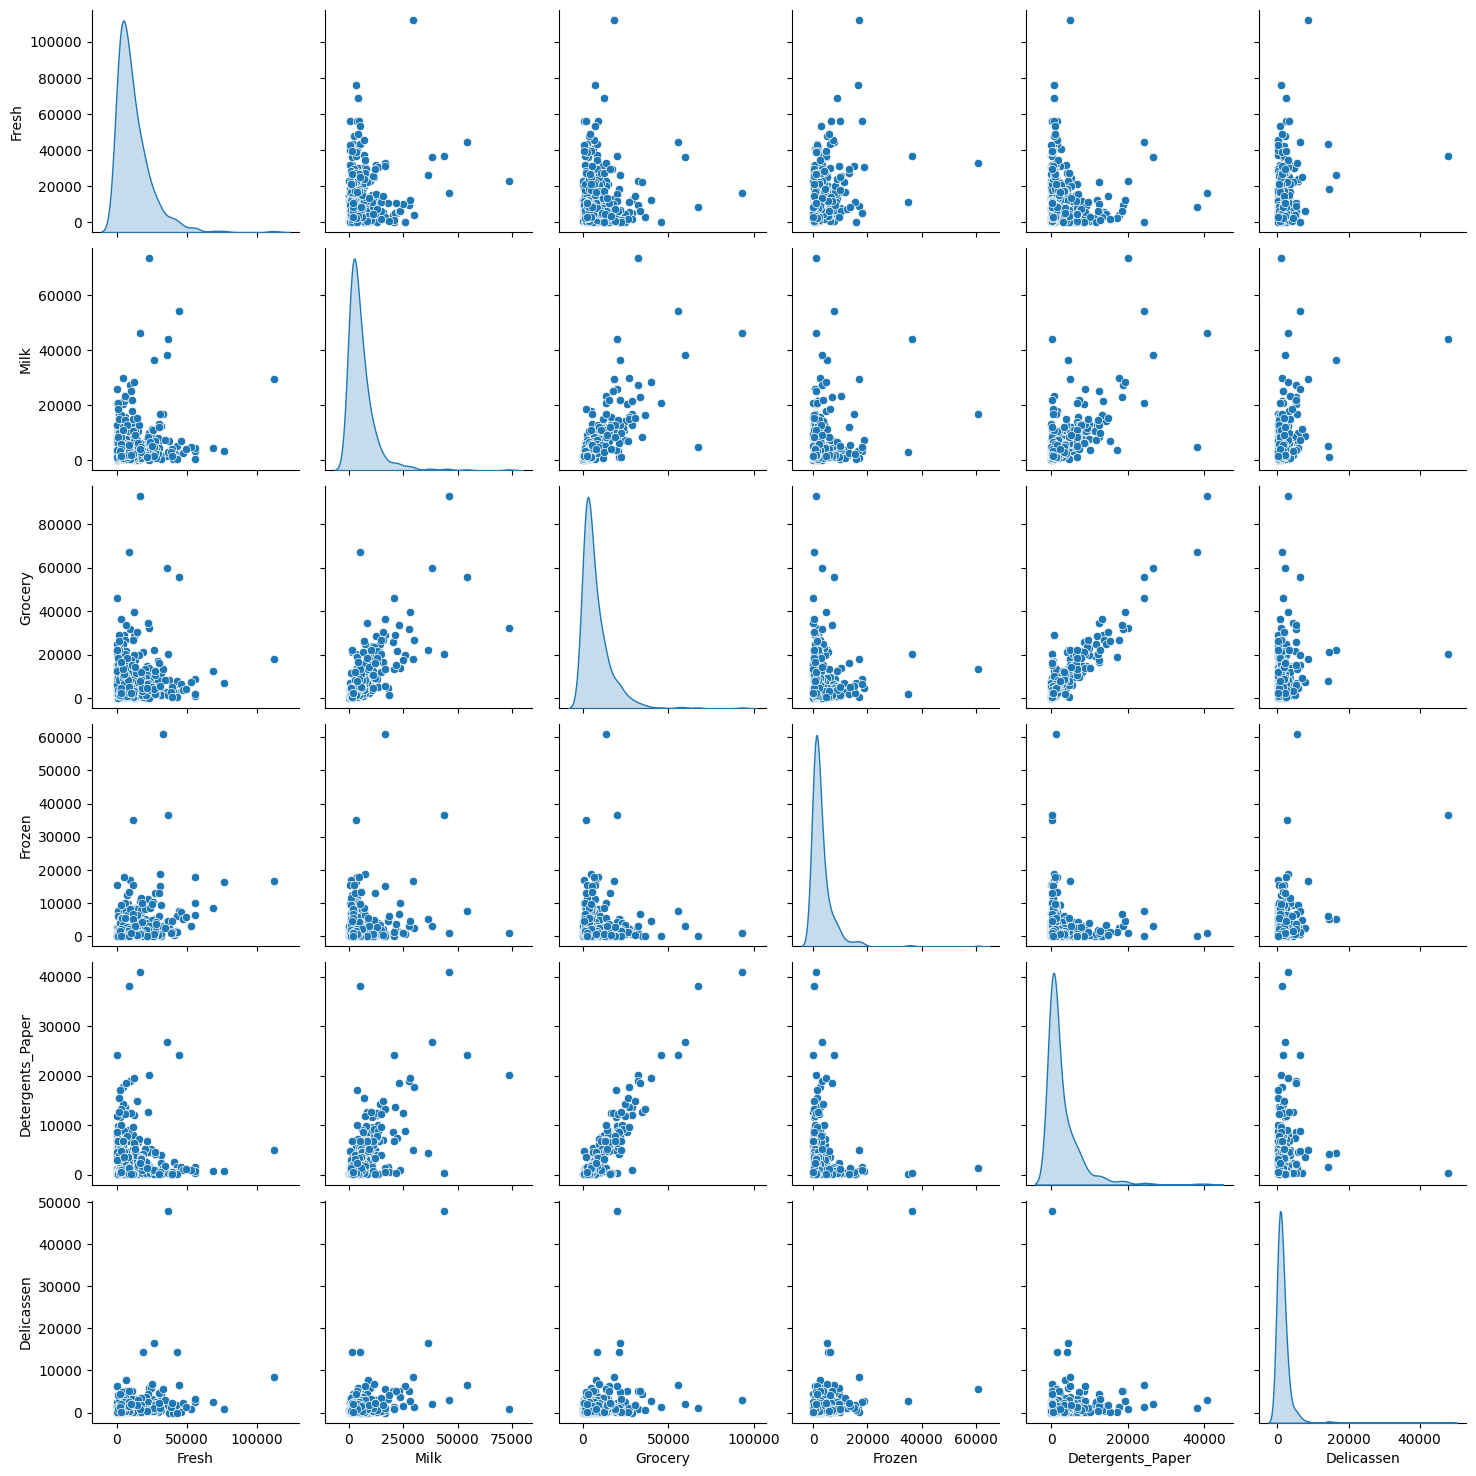

In [10]:
# Visualize pairwise plot to explore distributions
import seaborn as sns
sns.pairplot(wholesale, diag_kind='kde')
plt.show()

1. Right-skewed distributions
- Most features (Fresh, Milk, Grocery, Frozen, Detergents_Paper, Delicatessen) are right-skewed, meaning most customers spend small amounts, while a few spend extremely high amounts.
- This suggests outliers or high-value customers that may strongly influence averages.

2. Strong positive correlations
- There’s a clear positive relationship between Grocery and Detergents_Paper, and to some extent with Milk.
- These categories often move together — customers who spend more on groceries also tend to buy more cleaning or paper products.

3. Weak or no correlation
Fresh and Frozen show weak relationships with other categories.
This might indicate different customer segments — e.g., restaurants or fresh-food buyers behaving differently from grocery-type customers.

4. Possible feature redundancy
- Since Grocery, Milk, and Detergents_Paper are correlated, they might represent similar spending behavior.
- In modeling, one could consider dimensionality reduction (PCA) or feature selection to avoid redundancy.

5. Potential clustering structure
- The scatterplots suggest that certain groups of customers have distinct purchasing patterns (e.g., high in Fresh vs. high in Grocery),
→ a good hint that clustering (like K-Means) could reveal meaningful segments.

# Data preparation for Segmentation

I'll start with K-means because K-means works well when data is  1/ Normally distributed (no skew), and 2/ Standardized (mean = 0, standard deviation=1)

Furthermore, I can explore by using NMF which can be used on raw data, especially if the matrix is sparse

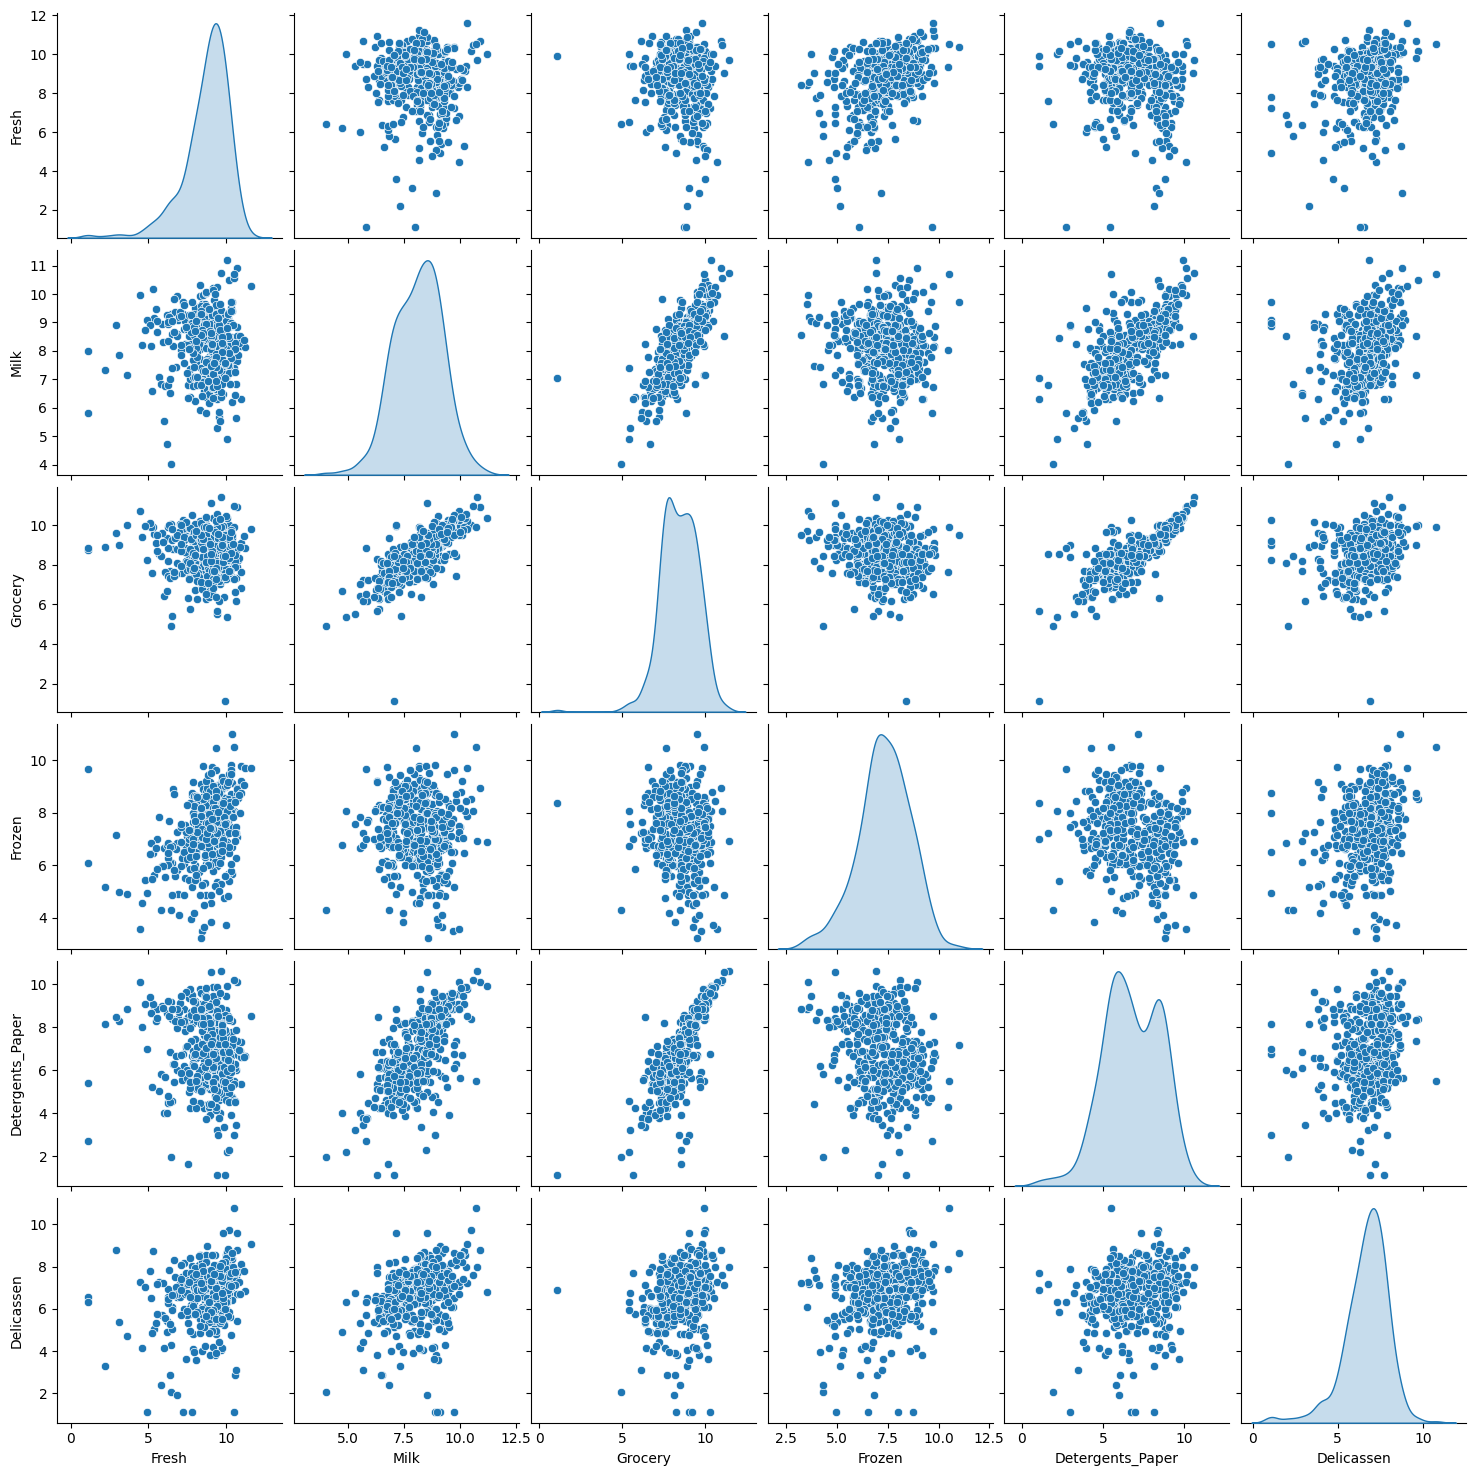

In [11]:
# Unskewing data with log-transformation

wholesale_log = np.log(wholesale)

sns.pairplot(wholesale_log, diag_kind='kde')
plt.show()

In [12]:
# Unskewing data with Box-Cos transformation
from scipy import stats 

def boxcox_df(x):
    x_boxcox, _ = stats.boxcox(x)
    return x_boxcox

wholesale_boxcox = wholesale.apply(boxcox_df, axis=0)

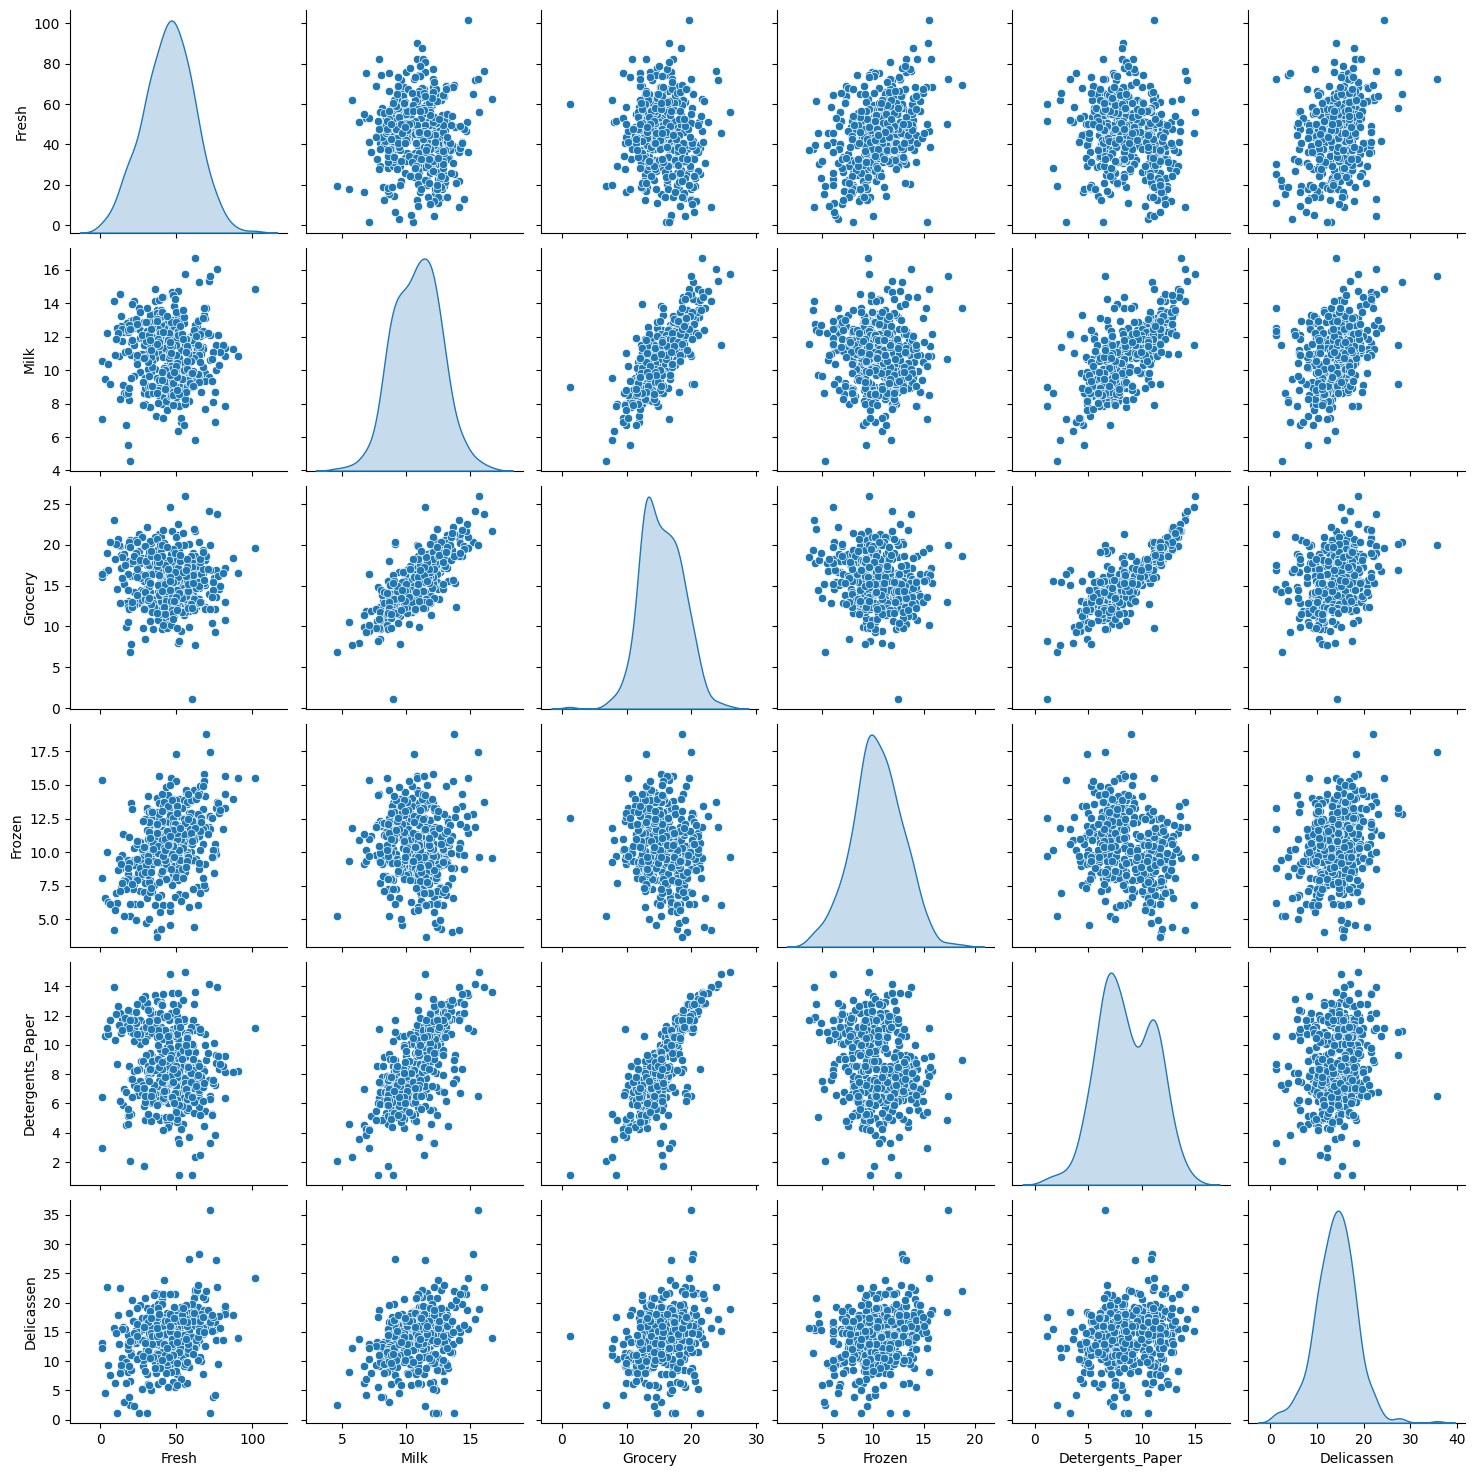

In [13]:
sns.pairplot(wholesale_boxcox, diag_kind='kde')
plt.show()

In [14]:
# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(wholesale_boxcox)
wholesale_scaled = scaler.transform(wholesale_boxcox)
wholesale_scaled_df = pd.DataFrame(data=wholesale_scaled,
                                   index=wholesale_boxcox.index,
                                   columns=wholesale_boxcox.columns)
wholesale_scaled_df.agg(['mean', 'std']).round()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
mean,-0.0,-0.0,0.0,-0.0,-0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0


# Building customer segmentation with K-means

In [15]:
k=4

In [16]:
from sklearn.cluster import KMeans 
kmeans = KMeans(n_clusters=k)
kmeans.fit(wholesale_scaled_df)
wholesale_kmeans4 = wholesale.assign(segment=kmeans.labels_)

# Building customer segmentation with NMF


In [17]:
from sklearn.decomposition import NMF
nmf = NMF(k)
nmf.fit(wholesale)
components = pd.DataFrame(nmf.components_, columns=wholesale.columns)

In [20]:
# Extracting segment assignment:
segment_weights = pd.DataFrame(
    nmf.transform(wholesale),
    index=wholesale.index,
    columns=components.index
)
segment_weights.index = wholesale.index
wholesale_nmf = wholesale.assign(segment = segment_weights.idxmax(axis=1))

# How many segments? k?

In [21]:
sse = {}

for k in range(1,11):
    kmeans = KMeans(n_clusters=k, random_state=333)
    kmeans.fit(wholesale_scaled_df)
    sse[k] = kmeans.inertia_

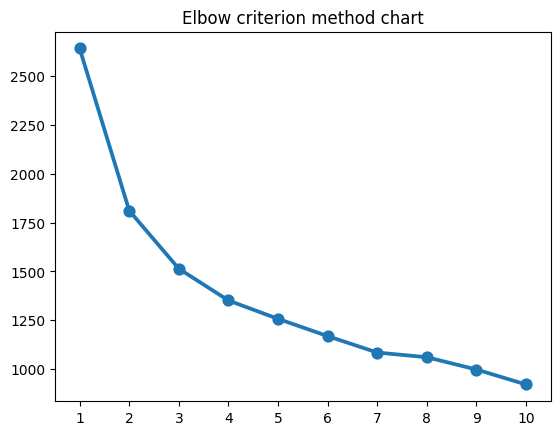

In [22]:
plt.title('Elbow criterion method chart')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

# Visualize and interpret segmentation solutions

In [23]:
kmeans4_averages = wholesale_kmeans4.groupby(['segment']).mean().round(0)
print(kmeans4_averages)

           Fresh     Milk  Grocery  Frozen  Detergents_Paper  Delicassen
segment                                                                 
0         4633.0   5964.0   9379.0   695.0            3738.0       685.0
1        10085.0   1724.0   2297.0  2508.0             390.0       634.0
2        24646.0   5049.0   5032.0  7578.0             839.0      3032.0
3        10135.0  13259.0  18977.0  1966.0            8252.0      2389.0


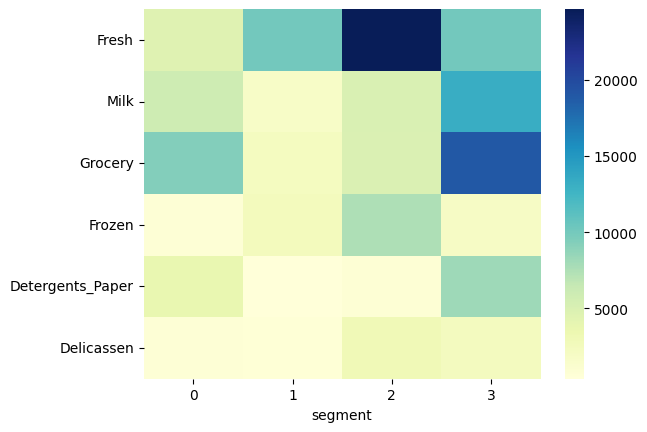

In [24]:
#Plot average K-means segmentation attributes
sns.heatmap(kmeans4_averages.T, cmap='YlGnBu')
plt.show()

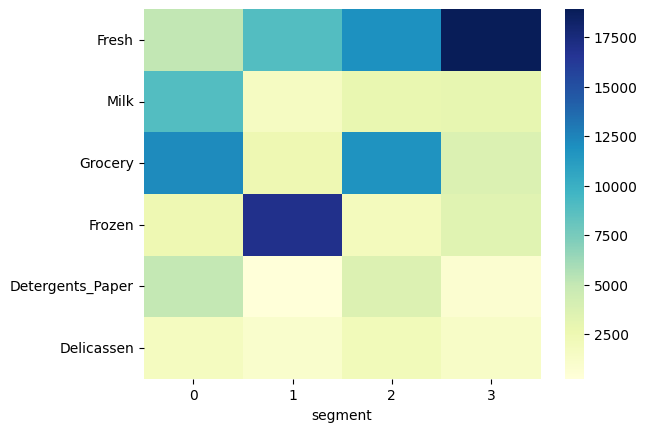

In [25]:
# Plot average NMF segmentation attributes
nmf4_averages = wholesale_nmf.groupby('segment').mean().round(0)
sns.heatmap(nmf4_averages.T, cmap='YlGnBu')
plt.show()